# Import Library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# To prevent Over-Fitting
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Layers Used for Our Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [2]:
dsA =  "/Users/zakariyyahusain/Downloads/data.Old/"
ds = "/Users/zakariyyahusain/Downloads/data/"

# Define Training Image In Constants

In [3]:
Img_Width=64
Img_Height=64
Img_Size=(Img_Width, Img_Height)
Img_Channels=3

# Sorting

In [4]:
def hyphen_split(filenames):
    if filenames.count("-") == 0:
        return filenames.split("-")[0]
    return "-".join(filenames.split("-", 2)[:2])

filenames = os.listdir("/Users/zakariyyahusain/Downloads/data/with_mask")
filenames1 = os.listdir("/Users/zakariyyahusain/Downloads/data/without_mask")

#Filesnames are added to the categories list For both With masks directory and without mask directory.
categories = []
for filename in filenames:
    category = filename
    categories.append(0)
for filename in filenames1:
    category = filename
    categories.append(1)
filenames = filenames + filenames1

#Creating Data frame consisting of the filenames along with their categories
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [5]:
df.head()

,filename,category
0,with_mask_2140.jpg,0
1,with_mask_1449.jpg,0
2,with_mask_2626.jpg,0
3,with_mask_942.jpg,0
4,with_mask_3538.jpg,0


In [6]:
df.tail()

,filename,category
7548,without_mask_2870.jpg,1
7549,without_mask_2858.jpg,1
7550,without_mask_2680.jpg,1
7551,without_mask_1389.jpg,1
7552,without_mask_2694.jpg,1


# See Total In count & Check Category sizes are even.

<AxesSubplot:>

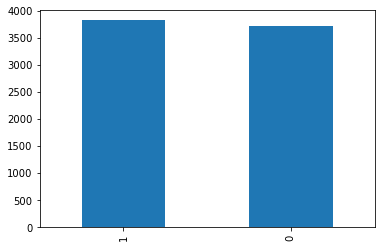

In [7]:

df['category'].value_counts().plot.bar()

# See sample image

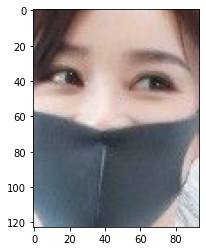

In [8]:
# iterate over one random image from either catagory
for x in range (1):  
    try:
        sample = random.choice(filenames)
        image = load_img(ds+"with_mask/"+sample)
        plt.imshow(image)
    except Exception as e:
        image = load_img(ds+"without_mask/"+sample)
        plt.imshow(image)

# Callbacks

In [9]:
# Define Early stopping.
earlystop = EarlyStopping(patience=10)
# Learning Rate Reduction when then accuracy not increase for 2 steps.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [10]:
callbacks = [earlystop, learning_rate_reduction]

# Prepration of data

In [11]:
# Conversion of 1 to No mask and 0 to Mask
df["category"] = df["category"].replace({0: 'Mask', 1: 'No_Mask'}) 

In [12]:
#Split Training & Validation arrays into random train and test subsets
train_df, validate_df = train_test_split(df, test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

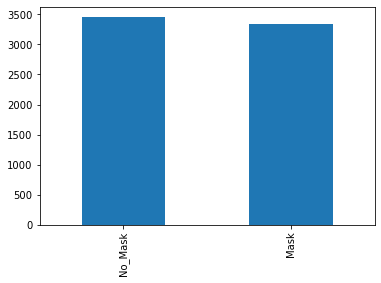

In [13]:
#Verify Training data Count remained the relatively even 
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

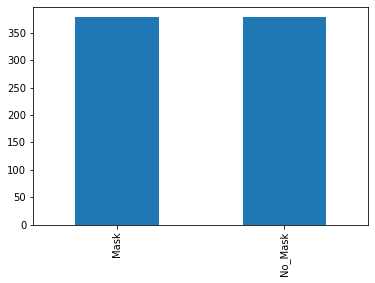

In [14]:
# Verify Validation data Count remained the same
validate_df['category'].value_counts().plot.bar()

In [15]:
# Defining of training constraints and batch size per iteration
total_training = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [16]:
# Defining of constraints for property of tensor images.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# One-hot encoding conversion of Column category into a string.
training_generator = train_datagen.flow_from_dataframe(
    train_df,
    dsA,
    x_col='filename',
    y_col='category',
    target_size=Img_Size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 6797 validated image filenames belonging to 2 classes.


### Validation Generator

In [17]:
# One-hot encoding conversion of Column category into a string.
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    dsA,
    x_col='filename',
    y_col='category',
    target_size=Img_Size,
    class_mode='categorical',
    batch_size=batch_size
)


Found 756 validated image filenames belonging to 2 classes.


In [18]:
#CNN Model Artichect
model = Sequential()

#Input Layer Using Inital Constraints
#First Convolutional Layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(Img_Width, Img_Height, Img_Channels)))
model.add(BatchNormalization())
#Down sampling using Max-pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Second Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Third Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Fully Connected Layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Output Layer
#Two Dense Layers for both catagories
model.add(Dense(2, activation='softmax')) 

# Defining learning rate decay and optimiser 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0

# Train Model

In [19]:
# Start Training for defined number epochs given that overfitting has not occured and reduction in learning rate has not occured
Run = False
epochs=3 if Run else 50
history = model.fit(
    training_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_training//batch_size,
    callbacks=callbacks
)

Epoch 1/50
140/453 [========>.....................] - ETA: 21s - loss: 0.6389 - accuracy: 0.7867

/Users/zakariyyahusain/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


453/453 [==============================] - 34s 73ms/step - loss: 0.5161 - accuracy: 0.8207 - val_loss: 0.9540 - val_accuracy: 0.6867
Epoch 2/50
453/453 [==============================] - 34s 75ms/step - loss: 0.3019 - accuracy: 0.8844 - val_loss: 0.3686 - val_accuracy: 0.8213
Epoch 3/50
453/453 [==============================] - 34s 74ms/step - loss: 0.2666 - accuracy: 0.8921 - val_loss: 0.1551 - val_accuracy: 0.9360
Epoch 4/50
453/453 [==============================] - 34s 74ms/step - loss: 0.2432 - accuracy: 0.9040 - val_loss: 0.1464 - val_accuracy: 0.9480
Epoch 5/50
453/453 [==============================] - 34s 75ms/step - loss: 0.2138 - accuracy: 0.9162 - val_loss: 0.1102 - val_accuracy: 0.9613
Epoch 6/50
453/453 [==============================] - 34s 74ms/step - loss: 0.2063 - accuracy: 0.9168 - val_loss: 0.2667 - val_accuracy: 0.8933
Epoch 7/50
453/453 [==============================] - 34s 75ms/step - loss: 0.1904 - accuracy: 0.9286 - val_loss: 0.1605 - val_accuracy: 0.9387

Ep

# Save Model

In [20]:
model.save_weights("modelnew13.h5")